# Multi-modal Unsupervised Image-to-Image Translation (MUNIT)

*Please note that this is an optional notebook, meant to introduce more advanced concepts if you're up for a challenge, so don't worry if you don't completely follow!*

It is recommended that you should already be familiar with:
 - Layer Normalization, from [Layer Normalization](https://arxiv.org/abs/1607.06450) (Ba et al. 2016)

### Goals

In this notebook, you will learn about and implement MUNIT, a method for unsupervised image-to-image translation, as proposed in [Multimodal Unsupervised Image-to-Image Translation](https://arxiv.org/abs/1804.04732) (Huang et al. 2018).

### Background

MUNIT builds off UNIT's proposition of a shared latent space, but MUNIT only uses a partially shared latent space. Specifically, the authors assume that the content latent space is shared between two domains, but the style latent spaces are unique to each domain.

Don't worry if you aren't familiar with UNIT - there will be a section that briefly goes over it!

## Overview

Let's begin with a quick overview of the UNIT framework and then move onto the MUNIT framework.

### UNIT

UNIT, proposed in [Unsupervised Image-to-Image Translation Networks](https://arxiv.org/abs/1703.00848) (Liu et al. 2018), is a method of image translation that assumes that images from different domains share a latent distribution.

Suppose that there are two image domains, $\mathcal{A}$ and $\mathcal{B}$. Images $(x_a, x_b) \in (\mathcal{A}, \mathcal{B})$ can be mapped to a shared latent space, $\mathcal{Z}$ via encoders $E_a: x_a \mapsto z$ and $E_b: x_b \mapsto z$, respectively. Synthetic images can be produced via generators $G_a: z \mapsto x_a'$ and $G_b: z \mapsto x_b'$, respectively. Note that the generators can generate self-reconstructed or domain-translated images for their respective domains.

And as per all other GAN frameworks, synthetic and real images, $(x_a',x_a)$, and $(x_b', x_b)$, are passed into discriminators, $D_a$ and $D_b$, respectively.

### MUNIT

Suppose that there are two image domains, $\mathcal{A}$ and $\mathcal{B}$. A pair of corresponding images $(x_a, x_b) \in (\mathcal{A}, \mathcal{B})$ can be generated as $x_a = F_a(c, s_a)$ and $x_b = F_b(c, s_b)$ where $c$ is a content vector from a shared distribution, $s_a, s_b$ are style vectors from distinct distributions, and $F_a, F_b$ are decoders that synthesize images from the content and style vectors.

The idea is that while the content between two domains can be shared (i.e. you can interchange horses and zebras in an image), the styles are different between the two (i.e. you would draw horses and zebras differently).

To learn the content and style distributions in training, the authors also assume some $E_a, E_b$ invert $F_a, F_b$, respectively. Specifically, $E_a^c: x_a \mapsto c$ extracts content and $E_a^s: x_a \mapsto s_a$ extracts style from images in domain $\mathcal{A}$. The same applies for $E_b^c(x_b)$ and $E_b^s(x_b)$ with images in domain $\mathcal{B}$. You can mix and match the content and style vectors from the two domains to translate images from between the two.

For example, if you take content $b$, $c_b = E_b^c(x_b)$, and style $a$, $s_a = E_a^s(x_a)$, and pass these through the horse decoder as $F_a(c_b, s_a)$, you should end up with the image $b$ drawn with characteristics of image $a$.

Don't worry if this is still unclear now! You'll go over this in more detail later in the notebook.

![Same- and cross-domain interaction of encoders and decoders](https://github.com/https-deeplearning-ai/GANs-Public/blob/master/MUNIT-Domains.png?raw=true)

*Model overview, taken from Figure 2 of [Multimodal Unsupervised Image-to-Image Translation](https://arxiv.org/abs/1804.04732) (Huang et al. 2018). The red and blue arrows denote encoders-decoder pairs within the same domain. Left: same domain image reconstruction. Right: cross-domain latent (content and style) vector reconstruction.*

## Getting Started
You will start by importing libraries and defining a visualization function. This code is borrowed from the CycleGAN notebook so you should already be familiar with this!

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
torch.manual_seed(0)


def show_tensor_images(x_real, x_fake):
    ''' For visualizing images '''
    image_tensor = torch.cat((x_fake[:1, ...], x_real[:1, ...]), dim=0)
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat, nrow=1)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()


import glob
import random
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# Inspired by https://github.com/aitorzip/PyTorch-CycleGAN/blob/master/datasets.py
class ImageDataset(Dataset):
    def __init__(self, root, transform=None, mode='train'):
        super().__init__()
        self.transform = transform
        self.files_A = sorted(glob.glob(os.path.join(root, '%sA' % mode) + '/*.*'))
        self.files_B = sorted(glob.glob(os.path.join(root, '%sB' % mode) + '/*.*'))
        if len(self.files_A) > len(self.files_B):
            self.files_A, self.files_B = self.files_B, self.files_A
        self.new_perm()
        assert len(self.files_A) > 0, "Make sure you downloaded the horse2zebra images!"

    def new_perm(self):
        self.randperm = torch.randperm(len(self.files_B))[:len(self.files_A)]

    def __getitem__(self, index):
        item_A = self.transform(Image.open(self.files_A[index % len(self.files_A)]))
        item_B = self.transform(Image.open(self.files_B[self.randperm[index]]))
        if item_A.shape[0] != 3: 
            item_A = item_A.repeat(3, 1, 1)
        if item_B.shape[0] != 3: 
            item_B = item_B.repeat(3, 1, 1)
        if index == len(self) - 1:
            self.new_perm()
        return item_A, item_B

    def __len__(self):
        return min(len(self.files_A), len(self.files_B))

In [2]:
if len(os.listdir(".")) < 3:
    !wget https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip
    !unzip horse2zebra.zip

--2021-01-19 13:51:31--  https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.244.190
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116867962 (111M) [application/zip]
Saving to: ‘horse2zebra.zip’

horse2zebra.zip     100%[===================>] 111.45M  1.25MB/s    in 68s     

2021-01-19 13:52:39 (1.64 MB/s) - ‘horse2zebra.zip’ saved [116867962/116867962]

Archive:  horse2zebra.zip
   creating: horse2zebra/
   creating: horse2zebra/trainA/
  inflating: horse2zebra/trainA/n02381460_6223.jpg  
  inflating: horse2zebra/trainA/n02381460_1567.jpg  
  inflating: horse2zebra/trainA/n02381460_3354.jpg  
  inflating: horse2zebra/trainA/n02381460_299.jpg  
  inflating: horse2zebra/trainA/n02381460_3001.jpg  
  inflating: horse2zebra/trainA/n02381460_4242.jpg  
  inflating: horse2zebra/train

## Subcomponents: Layers and Blocks

MUNIT has a few key subcomponents that are used throughout the model. It'll generally make your life easier if you implement the smaller parts first!

### Adaptive Instance Normalization (AdaIN)

You've already learned about this layer in StyleGAN and seen a very similar cousin - class-conditional batch normalization - in the BigGAN components notebook.

The authors enhance the linear layers for scale and shift with a multi-layer perceptron (MLP), which is essentially just a series of linear layers to help learn more complex representations. See the figure in **Submodules** and the notes in **Submodules: Decoder** for more details.

In [4]:
class AdaptiveInstanceNorm2d(nn.Module):
    '''
    AdaptiveInstanceNorm2d Class
    Values:
        channels: the number of channels the image has, a scalar
        s_dim: the dimension of the style tensor (s), a scalar
        h_dim: the hidden dimension of the MLP, a scalar
    '''

    def __init__(self, channels, s_dim=8, h_dim=256):
        super().__init__()

        self.instance_norm = nn.InstanceNorm2d(channels, affine=False)
        self.style_scale_transform = self.mlp(s_dim, h_dim, channels)
        self.style_shift_transform = self.mlp(s_dim, h_dim, channels)

    @staticmethod
    def mlp(self, in_dim, h_dim, out_dim):
        return nn.Sequential(
            nn.Linear(in_dim, h_dim),
            nn.ReLU(inplace=True),
            nn.Linear(h_dim, h_dim),
            nn.ReLU(inplace=True),
            nn.Linear(h_dim, out_dim),
        )

    def forward(self, image, w):
        '''
        Function for completing a forward pass of AdaIN: Given an image and a style, 
        returns the normalized image that has been scaled and shifted by the style.
        Parameters:
          image: the feature map of shape (n_samples, channels, width, height)
          w: the intermediate noise vector w to be made into the style (y)
        '''
        normalized_image = self.instance_norm(image)
        style_scale = self.style_scale_transform(w)[:, :, None, None]
        style_shift = self.style_shift_transform(w)[:, :, None, None]
        transformed_image = style_scale * normalized_image + style_shift
        return transformed_image

### Layer Normalization

MUNIT uses layer normalization in the upsampling layers of the decoder. Proposed in [Layer Normalization](https://arxiv.org/abs/1607.06450) (Ba et al. 2016), layer normalization operates similarly to all other normalization techniques like batch normalization, but instead of normalizing across minibatch examples per channel, it normalizes across channels per minibatch example.

Layer normalization is actually much more prevalent in NLP and but quite rare in computer vision. However, batch normalization is not viable here due to training batch sizes of 1 and instance normalization is undesirable because it normalizes the statistics at each position to a standard Gaussian, which removes style features.

Pytorch implements this as [nn.LayerNorm](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html) but requires precomputed spatial size for initialization to accomodate for 1D, 2D, and 3D inputs. For convenience, let's implement a size-agnostic layer normalization module for 2D inputs (i.e. images).

In [5]:
class LayerNorm2d(nn.Module):
    '''
    LayerNorm2d Class
    Values:
        channels: number of channels in input, a scalar
        affine: whether to apply affine denormalization, a bool
    '''

    def __init__(self, channels, eps=1e-5, affine=True):
        super().__init__()
        self.affine = affine
        self.eps = eps

        if self.affine:
            self.gamma = nn.Parameter(torch.rand(channels))
            self.beta = nn.Parameter(torch.zeros(channels))

    def forward(self, x):
        mean = x.flatten(1).mean(1).reshape(-1, 1, 1, 1)
        std = x.flatten(1).std(1).reshape(-1, 1, 1, 1)

        x = (x - mean) / (std + self.eps)

        if self.affine:
            x = x * self.gamma.reshape(1, -1, 1, 1) + self.beta.reshape(1, -1, 1, 1)

        return x

### Residual Block

By now, you should already be very familiar with residual blocks. Below is an implementation that supports both adaptive and non-adaptive instance normalization layers, since both are used throughout the model.

In [6]:
class ResidualBlock(nn.Module):
    '''
    ResidualBlock Class
    Values:
        channels: number of channels throughout residual block, a scalar
        s_dim: the dimension of the style tensor (s), a scalar
        h_dim: the hidden dimension of the MLP, a scalar
    '''

    def __init__(self, channels, s_dim=None, h_dim=None):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.utils.spectral_norm(
                nn.Conv2d(channels, channels, kernel_size=3)
            ),
        )
        self.conv2 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.utils.spectral_norm(
                nn.Conv2d(channels, channels, kernel_size=3)
            ),
        )
        self.use_style = s_dim is not None and h_dim is not None
        if self.use_style:
            self.norm1 = AdaptiveInstanceNorm2d(channels, s_dim, h_dim)
            self.norm2 = AdaptiveInstanceNorm2d(channels, s_dim, h_dim)
        else:
            self.norm1 = nn.InstanceNorm2d(channels)
            self.norm2 = nn.InstanceNorm2d(channels)

        self.activation = nn.ReLU()

    def forward(self, x, s=None):
        x_id = x
        x = self.conv1(x)
        x = self.norm1(x, s) if self.use_style else self.norm1(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.norm2(x, s) if self.use_style else self.norm2(x)
        return x + x_id

## Submodules: Encoders and Decoder

Now that you're all set up and implemented some basic building blocks, let's take a look at the content encoder, style encoder, and decoder! These will be used in the generator.

![Same- and cross-domain interaction of encoders and decoders](https://github.com/https-deeplearning-ai/GANs-Public/blob/master/MUNIT-Generator.png?raw=true)

*Generator architecture, taken from Figure 3 of [Multimodal Unsupervised Image-to-Image Translation](https://arxiv.org/abs/1804.04732) (Huang et al. 2018). Content encoder: generates a downsampled representation of the original. Style encoder: generates a style code from the original. Decoder: synthesizes a fake image from content code, infused with style info.*

*Note: the official implementation feeds style code through a multi-layer perceptron (MLP) and assigns these values to the scale and shift parameters in the instance normalization layers. To be compatible with our previous definitions of* `AdaIN`*, your implementation will simply apply the MLP within* `AdaptiveInstanceNorm2d`.

### Content Encoder

The content encoder is similar to many encoders you've already seen: it simply downsamples the input image and feeds it through residual blocks to obtain a condensed representation.

In [7]:
class ContentEncoder(nn.Module):
    '''
    ContentEncoder Class
    Values:
        base_channels: number of channels in first convolutional layer, a scalar
        n_downsample: number of downsampling layers, a scalar
        n_res_blocks: number of residual blocks, a scalar
    '''

    def __init__(self, base_channels=64, n_downsample=2, n_res_blocks=4):
        super().__init__()

        channels = base_channels

        # Input convolutional layer
        layers = [
            nn.ReflectionPad2d(3),
            nn.utils.spectral_norm(
                nn.Conv2d(3, channels, kernel_size=7)
            ),
            nn.InstanceNorm2d(channels),
            nn.ReLU(inplace=True),
        ]

        # Downsampling layers
        for i in range(n_downsample):
            layers += [
                nn.ReflectionPad2d(1),
                nn.utils.spectral_norm(
                    nn.Conv2d(channels, 2 * channels, kernel_size=4, stride=2)
                ),
                nn.InstanceNorm2d(2 * channels),
                nn.ReLU(inplace=True),
            ]
            channels *= 2

        # Residual blocks
        layers += [
            ResidualBlock(channels) for _ in range(n_res_blocks)
        ]
        self.layers = nn.Sequential(*layers)
        self.out_channels = channels

    def forward(self, x):
        return self.layers(x)

    @property
    def channels(self):
        return self.out_channels

### Style Encoder

The style encoder operates similarly to the content encoder but instead of residual blocks, it uses global pooling and fully-connected layers to distill the input image to its style vector. An important difference is that the style encoder doesn't use any normalization layers, since they will remove the feature statistics that encode style. This style code will be passed to the decoder, which use this along with the content code to synthesize a fake image.

In [8]:
class StyleEncoder(nn.Module):
    '''
    StyleEncoder Class
    Values:
        base_channels: number of channels in first convolutional layer, a scalar
        n_downsample: number of downsampling layers, a scalar
        s_dim: the dimension of the style tensor (s), a scalar
    '''

    n_deepen_layers = 2

    def __init__(self, base_channels=64, n_downsample=4, s_dim=8):
        super().__init__()

        channels = base_channels

        # Input convolutional layer
        layers = [
            nn.ReflectionPad2d(3),
            nn.utils.spectral_norm(
                nn.Conv2d(3, channels, kernel_size=7, padding=0)
            ),
            nn.ReLU(inplace=True),
        ]

        # Downsampling layers
        for i in range(self.n_deepen_layers):
            layers += [
                nn.ReflectionPad2d(1),
                nn.utils.spectral_norm(
                    nn.Conv2d(channels, 2 * channels, kernel_size=4, stride=2)
                ),
                nn.ReLU(inplace=True),
            ]
            channels *= 2
        for i in range(n_downsample - self.n_deepen_layers):
            layers += [
                nn.ReflectionPad2d(1),
                nn.utils.spectral_norm(
                    nn.Conv2d(channels, channels, kernel_size=4, stride=2)
                ),
                nn.ReLU(inplace=True),
            ]

        # Apply global pooling and pointwise convolution to style_channels
        layers += [
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, s_dim, kernel_size=1),
        ]

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

### Decoder

As with all encoder-decoder frameworks, the decoder serves to synthesize images from the latent information passed through by the encoder. In this case, the decoder works with both content and style encodings.

You can think of the content encoder and decoder as the backbone of the encoder-decoder framework with style information injected into the residual blocks via `AdaIN` layers.

Note: the official implementation feeds style code through a multi-layer perceptron (MLP) and assigns these values to the scale and shift parameters in the instance normalization layers. To be compatible with the previous definitions of `AdaIN` in this course, your implementation will simply apply the MLP within `AdaptiveInstanceNorm2d`.

Let's take a look at the implementation!

In [9]:
class Decoder(nn.Module):
    '''
    Decoder Class
    Values:
        in_channels: number of channels from encoder output, a scalar
        n_upsample: number of upsampling layers, a scalar
        n_res_blocks: number of residual blocks, a scalar
        s_dim: the dimension of the style tensor (s), a scalar
        h_dim: the hidden dimension of the MLP, a scalar
    '''

    def __init__(self, in_channels, n_upsample=2, n_res_blocks=4, s_dim=8, h_dim=256):
        super().__init__()

        channels = in_channels

        # Residual blocks with AdaIN
        self.res_blocks = nn.ModuleList([
            ResidualBlock(channels, s_dim) for _ in range(n_res_blocks)
        ])

        # Upsampling blocks
        layers = []
        for i in range(n_upsample):
            layers += [
                nn.Upsample(scale_factor=2),
                nn.ReflectionPad2d(2),
                nn.utils.spectral_norm(
                    nn.Conv2d(channels, channels // 2, kernel_size=5)
                ),
                LayerNorm2d(channels // 2),
            ]
            channels //= 2
        
        layers += [
            nn.ReflectionPad2d(3),
            nn.utils.spectral_norm(
                nn.Conv2d(channels, 3, kernel_size=7)
            ),
            nn.Tanh(),
        ]
        self.layers = nn.Sequential(*layers)

    def forward(self, x, s):
        for res_block in self.res_blocks:
            x = res_block(x, s=s)
        x = self.layers(x)
        return x

## Modules: Generator, Discriminator, and Loss

Now you're ready to implement MUNIT generator and discriminator, as well as the composite loss function that ties everything together in training.

### Generator

The generator is essentially just comprised of the two encoders and one decoder implemented in the previous section, so let's wrap everything in a `Generator` module!

In [10]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        base_channels: number of channels in first convolutional layer, a scalar
        n_downsample: number of downsampling layers, a scalar
        n_res_blocks: number of residual blocks, a scalar
        s_dim: the dimension of the style tensor (s), a scalar
        h_dim: the hidden dimension of the MLP, a scalar
    '''

    def __init__(
        self,
        base_channels: int = 64,
        n_c_downsample: int = 2,
        n_s_downsample: int = 4,
        n_res_blocks: int = 4,
        s_dim: int = 8,
        h_dim: int = 256,
    ):
        super().__init__()
        self.c_enc = ContentEncoder(
            base_channels=base_channels, n_downsample=n_c_downsample, n_res_blocks=n_res_blocks,
        )
        self.s_enc = StyleEncoder(
            base_channels=base_channels, n_downsample=n_s_downsample, s_dim=s_dim,
        )
        self.dec = Decoder(
            self.c_enc.channels, n_upsample=n_c_downsample, n_res_blocks=n_res_blocks, s_dim=s_dim, h_dim=h_dim,
        )

    def encode(self, x):
        content = self.c_enc(x)
        style = self.s_enc(x)
        return (content, style)
    
    def decode(self, content, style):
        return self.dec(content, style)

### Discriminator

The discriminator, identical to the one used in Pix2PixHD, is comprised of several PatchGAN discriminators operating at different scales. For details on how these work together, take a look at the Pix2PixHD optional notebook.

The discriminator is trained with the least squares objective.

In [11]:
class Discriminator(nn.Module):
    '''
    Generator Class
    Values:
        base_channels: number of channels in first convolutional layer, a scalar
        n_layers: number of downsampling layers, a scalar
        n_discriminators: number of discriminators (all at different scales), a scalar
    '''

    def __init__(
        self,
        base_channels: int = 64,
        n_layers: int = 3,
        n_discriminators: int = 3,
    ):
        super().__init__()

        self.discriminators = nn.ModuleList([
            self.patchgan_discriminator(base_channels, n_layers) for _ in range(n_discriminators)
        ])

        self.downsample = nn.AvgPool2d(3, stride=2, padding=1, count_include_pad=False)

    @staticmethod
    def patchgan_discriminator(base_channels, n_layers):
        '''
        Function that constructs and returns one PatchGAN discriminator module.
        '''
        channels = base_channels
        # Input convolutional layer
        layers = [
            nn.ReflectionPad2d(1),
            nn.utils.spectral_norm(
                nn.Conv2d(3, channels, kernel_size=4, stride=2),
            ),
            nn.LeakyReLU(0.2, inplace=True),
        ]

        # Hidden convolutional layers
        for _ in range(n_layers):
            layers += [
                nn.ReflectionPad2d(1),
                nn.utils.spectral_norm(
                    nn.Conv2d(channels, 2 * channels, kernel_size=4, stride=2)
                ),
                nn.LeakyReLU(0.2, inplace=True),
            ]
            channels *= 2

        # Output projection layer
        layers += [
            nn.utils.spectral_norm(
                nn.Conv2d(channels, 1, kernel_size=1)
            ),
        ]
        return nn.Sequential(*layers)

    def forward(self, x):
        outputs = []
        for discriminator in self.discriminators:
            outputs.append(discriminator(x))
            x = self.downsample(x)
        return outputs

### Loss Functions

There are a lot of moving parts in MUNIT so this section will break down which parts interact with which other parts. Recall from earlier our notation:
 - Image domains:
    \begin{align*}
        a &\in \mathcal{A} \\
        b &\in \mathcal{B}
    \end{align*}
 - Encoders ($E$):
    \begin{align*}
        E_a^c: a \mapsto c_a, &\quad E_a^s: a \mapsto s_a \\
        E_b^c: b \mapsto c_b, &\quad E_b^s: b \mapsto s_b
    \end{align*}
 - Decoders ($F$):
    \begin{align*}
        F_a&: (c_*, s_a) \mapsto a' \\
        F_b&: (c_*, s_b) \mapsto b'
    \end{align*}
 - Generators ($G$):
    \begin{align*}
        G_a(a, b) &= F_a(E_b^c(b), E_a^s(a)) \\
        G_b(b, a) &= F_b(E_a^c(a), E_b^s(b))
    \end{align*}
 - Discriminators ($D$):
    \begin{align*}
        D_a&: a' \mapsto p \in \mathbb{R} \\
        D_b&: b' \mapsto p \in \mathbb{R}
    \end{align*}

**Image Reconstruction Loss**

The model should be able to encode and decode a reconstruction of the image. For domain $\mathcal{A}$, this can be expressed as

\begin{align*}
    \mathcal{L}_{\text{recon}}^a &= \mathbb{E}_{a\sim p(a)}\left|\left|F_a(E_a^c(a), E_a^s(a)) - a\right|\right|_1
\end{align*}

and for domain $\mathcal{B}$, this can be expressed as

\begin{align*}
    \mathcal{L}_{\text{recon}}^b &= \mathbb{E}_{b\sim p(b)}\left|\left|F_b(E_b^c(b), E_b^s(b)) - b\right|\right|_1.
\end{align*}

**Latent Reconstruction Loss**

The same principle from above applies to the latent space: decoding and encoding a latent vector should reproduce the original. Don't worry if the equations look complicated! Just know that intuitively, passing in different content and style vectors through the encoders should yield those same input vectors. For domain $\mathcal{A}$, this can be expressed as

\begin{align*}
    \mathcal{L}_{\text{recon}}^{c_b} &= \mathbb{E}_{c_b\sim p(c_b),s_a\sim q(s_a)}\left|\left|E_a^c(F_a(c_b, s_a)) - c_a\right|\right|_1 \\
    \mathcal{L}_{\text{recon}}^{s_a} &= \mathbb{E}_{c_b\sim p(c_b),s_a\sim q(s_a)}\left|\left|E_a^s(F_a(c_b, s_a)) - s_b\right|\right|_1
\end{align*}

and for domain $\mathcal{B}$, this can be expressed as

\begin{align*}
    \mathcal{L}_{\text{recon}}^{c_a} &= \mathbb{E}_{c_a\sim p(c_a),s_b\sim q(s_b)}\left|\left|E_b^c(F_b(c_a, s_b)) - c_b\right|\right|_1 \\
    \mathcal{L}_{\text{recon}}^{s_b} &= \mathbb{E}_{c_a\sim p(c_a),s_b\sim q(s_b)}\left|\left|E_b^s(F_b(c_a, s_b)) - s_a\right|\right|_1
\end{align*}

**Adversarial Loss**

As with all other GANs, MUNIT is trained with adversarial loss. The authors opt for the LSGAN least-squares objective. For domain $\mathcal{A}$, this can be expressed as

\begin{align*}
    \mathcal{L}_{\text{GAN}}^a &= \mathbb{E}_{c_b\sim p(c_b),s_a\sim q(s_a)}\left[(1 - D_a(G_a(c_b, s_a)))^2\right] + \mathbb{E}_{a\sim p(a)}\left[D_a(a)^2\right]
\end{align*}

and for domain $\mathcal{B}$, this can be expressed as

\begin{align*}
    \mathcal{L}_{\text{GAN}}^b &= \mathbb{E}_{c_a\sim p(c_a),s_b\sim q(s_b)}\left[(1 - D_b(G_b(c_a, s_b)))^2\right] + \mathbb{E}_{b\sim p(b)}\left[D_b(b)^2\right]
\end{align*}

**Total Loss**

The total loss can now be expressed in terms of the individual losses from above, so the objective can be expressed as

\begin{align*}
    \mathcal{L}(E_a, E_b, F_a, F_b, D_a, D_b) &= \mathcal{L}_{\text{GAN}}^a + \mathcal{L}_{\text{GAN}}^b + \lambda_x(\mathcal{L}_{\text{recon}}^a + \mathcal{L}_{\text{recon}}^b) + \lambda_c(\mathcal{L}_{\text{recon}}^{c_a} + \mathcal{L}_{\text{recon}}^{c_b}) + \lambda_s(\mathcal{L}_{\text{recon}}^{s_a} + \mathcal{L}_{\text{recon}}^{s_b})
\end{align*}

And now the fun part: implementing this ginormous composite loss!

In [12]:
class GinormousCompositeLoss(nn.Module):
    '''
    GinormousCompositeLoss Class: implements all losses for MUNIT
    '''

    @staticmethod
    def image_recon_loss(x, gen):
        c, s = gen.encode(x)
        recon = gen.decode(c, s)
        return F.l1_loss(recon, x), c, s

    @staticmethod
    def latent_recon_loss(c, s, gen):
        x_fake = gen.decode(c, s)
        recon = gen.encode(x_fake)
        return F.l1_loss(recon[0], c), F.l1_loss(recon[1], s), x_fake

    @staticmethod
    def adversarial_loss(x, dis, is_real):
        preds = dis(x)
        target = torch.ones_like if is_real else torch.zeros_like
        loss = 0.0
        for pred in preds:
            loss += F.mse_loss(pred, target(pred))
        return loss

### Optional Loss Functions

The authors also propose a couple of auxiliary loss functions that can help improve convergence. This section will just go over these losses but implementation is left as an exercise for the curious reader :)

**Style-augmented Cycle Consistency**

You've already heard of cycle consistency from CycleGAN, which implies that an image translated to the target domain and back should be identical to the original.

Intuitively, style-augmented cycle consistency implies that an image translated to the target domain and back using the original style should result in the original image. Style-augmented cycle consistency is implicitly encouraged
by the reconstruction losses, but the authors note that explicitly enforcing it could be useful in some cases.

**Domain Invariant Perceptual Loss**

You're probably already familiar with perceptual loss, which is usually implemented via MSE loss between feature maps of fake and real images. However, because the images in the domains are unpaired, pixel-wise loss may not be optimal, since each values at each position do not correspond spatially.

The authors get around this discrepancy by applying instance normalization to the feature maps. This normalizes the values per channel for each position in the feature maps, so MSE loss penalizes the difference in statistics rather than raw pixel value.

## Model: MUNIT

Now that you've got all the necessary modules, let's see how we can put them all together.

In [13]:
class MUNIT(nn.Module):
    def __init__(
        self,
        gen_channels: int = 64,
        n_c_downsample: int = 2,
        n_s_downsample: int = 4,
        n_res_blocks: int = 4,
        s_dim: int = 8,
        h_dim: int = 256,
        dis_channels: int = 64,
        n_layers: int = 3,
        n_discriminators: int = 3,
    ):
        super().__init__()

        self.gen_a = Generator(
            base_channels=gen_channels, n_c_downsample=n_c_downsample, n_s_downsample=n_s_downsample, n_res_blocks=n_res_blocks, s_dim=s_dim, h_dim=h_dim,
        )
        self.gen_b = Generator(
            base_channels=gen_channels, n_c_downsample=n_c_downsample, n_s_downsample=n_s_downsample, n_res_blocks=n_res_blocks, s_dim=s_dim, h_dim=h_dim,
        )
        self.dis_a = Discriminator(
            base_channels=dis_channels, n_layers=n_layers, n_discriminators=n_discriminators,
        )
        self.dis_b = Discriminator(
            base_channels=dis_channels, n_layers=n_layers, n_discriminators=n_discriminators,
        )
        self.s_dim = s_dim
        self.loss = GinormousCompositeLoss

    def forward(self, x_a, x_b):
        s_a = torch.randn(x_a.size(0), self.s_dim, 1, 1, device=x_a.device).to(x_a.dtype)
        s_b = torch.randn(x_b.size(0), self.s_dim, 1, 1, device=x_b.device).to(x_b.dtype)

        # Encode real x and compute image reconstruction loss
        x_a_loss, c_a, s_a_fake = self.loss.image_recon_loss(x_a, self.gen_a)
        x_b_loss, c_b, s_b_fake = self.loss.image_recon_loss(x_b, self.gen_b)

        # Decode real (c, s) and compute latent reconstruction loss
        c_b_loss, s_a_loss, x_ba = self.loss.latent_recon_loss(c_b, s_a, self.gen_a)
        c_a_loss, s_b_loss, x_ab = self.loss.latent_recon_loss(c_a, s_b, self.gen_b)

        # Compute adversarial losses
        gen_a_adv_loss = self.loss.adversarial_loss(x_ba, self.dis_a, True)
        gen_b_adv_loss = self.loss.adversarial_loss(x_ab, self.dis_b, True)

        # Sum up losses for gen
        gen_loss = (
            10 * x_a_loss + c_b_loss + s_a_loss + gen_a_adv_loss + \
            10 * x_b_loss + c_a_loss + s_b_loss + gen_b_adv_loss
        )

        # Sum up losses for dis
        dis_loss = (
            self.loss.adversarial_loss(x_ba.detach(), self.dis_a, False) + \
            self.loss.adversarial_loss(x_a.detach(), self.dis_a, True) + \
            self.loss.adversarial_loss(x_ab.detach(), self.dis_b, False) + \
            self.loss.adversarial_loss(x_b.detach(), self.dis_b, True)
        )

        return gen_loss, dis_loss, x_ab, x_ba

### Training

Now you're ready to train MUNIT! Let's start by setting some optimization parameters and initializing everything you'll need for training.

In [14]:
# Initialize model
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, a=0, mode='fan_in')

munit_config = {
    'gen_channels': 64,
    'n_c_downsample': 2,
    'n_s_downsample': 4,
    'n_res_blocks': 4,
    's_dim': 8,
    'h_dim': 256,
    'dis_channels': 64,
    'n_layers': 3,
    'n_discriminators': 3,
}
device = 'cuda' if torch.cuda.is_available() else 'cpu'
munit = MUNIT(**munit_config).to(device).apply(weights_init)

# Initialize dataloader
transform = transforms.Compose([
    transforms.Resize(286),
    transforms.RandomCrop(256),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])
dataloader = DataLoader(
    ImageDataset('horse2zebra', transform),
    batch_size=1, pin_memory=True, shuffle=True,
)

# Initialize optimizers
gen_params = list(munit.gen_a.parameters()) + list(munit.gen_b.parameters())
dis_params = list(munit.dis_a.parameters()) + list(munit.dis_b.parameters())
gen_optimizer = torch.optim.Adam(gen_params, lr=1e-4, betas=(0.5, 0.999))
dis_optimizer = torch.optim.Adam(dis_params, lr=1e-4, betas=(0.5, 0.999))

 47%|████▋     | 499/1067 [05:21<06:09,  1.54it/s]

Step 500: [G loss: 9.22638][D loss: 2.88833]


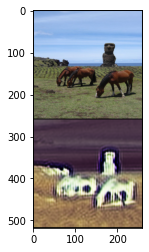

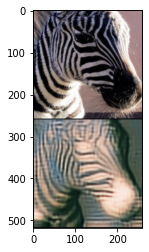

 94%|█████████▎| 999/1067 [10:44<00:43,  1.57it/s]

Step 1000: [G loss: 8.43830][D loss: 2.70084]


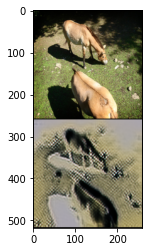

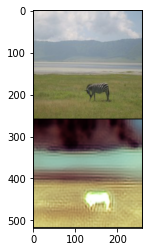

 40%|████      | 432/1067 [04:37<06:45,  1.56it/s]

Step 1500: [G loss: 8.30849][D loss: 2.66217]


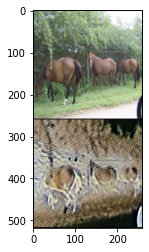

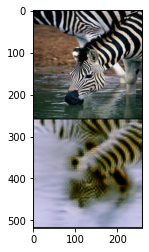

 87%|████████▋ | 932/1067 [09:59<01:25,  1.58it/s]

Step 2000: [G loss: 8.02721][D loss: 2.63142]


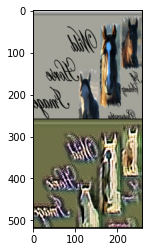

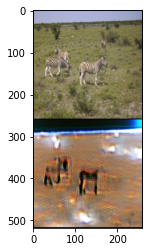

 34%|███▍      | 365/1067 [03:54<07:38,  1.53it/s]

Step 2500: [G loss: 8.04326][D loss: 2.65217]


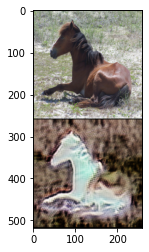

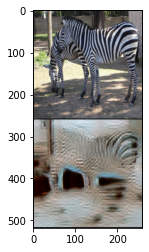

 81%|████████  | 865/1067 [09:13<02:07,  1.59it/s]

Step 3000: [G loss: 7.83681][D loss: 2.63404]


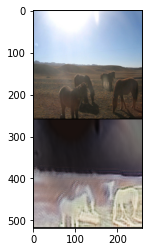

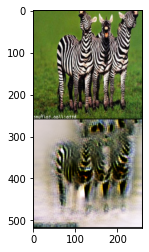

 28%|██▊       | 298/1067 [03:10<08:00,  1.60it/s]

Step 3500: [G loss: 7.70879][D loss: 2.67584]


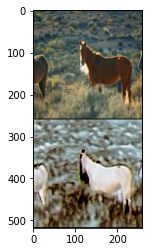

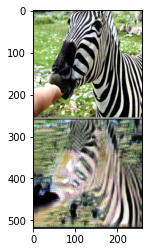

 75%|███████▍  | 798/1067 [08:30<02:51,  1.57it/s]

Step 4000: [G loss: 7.67061][D loss: 2.65518]


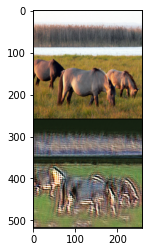

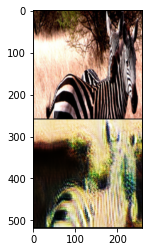

 22%|██▏       | 231/1067 [02:27<08:52,  1.57it/s]

Step 4500: [G loss: 7.53183][D loss: 2.69025]


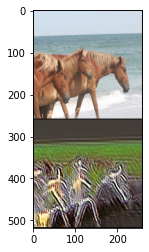

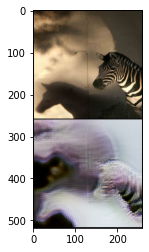

 69%|██████▊   | 731/1067 [07:46<03:33,  1.57it/s]

Step 5000: [G loss: 7.39574][D loss: 2.67679]


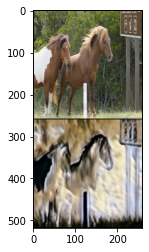

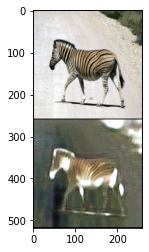

 15%|█▌        | 164/1067 [01:43<09:34,  1.57it/s]

Step 5500: [G loss: 7.41904][D loss: 2.69979]


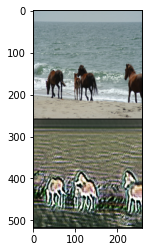

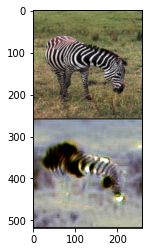

 62%|██████▏   | 664/1067 [07:02<04:19,  1.55it/s]

Step 6000: [G loss: 7.30517][D loss: 2.69390]


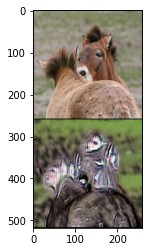

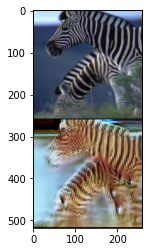

  9%|▉         | 97/1067 [01:01<10:29,  1.54it/s]

Step 6500: [G loss: 7.35255][D loss: 2.68953]


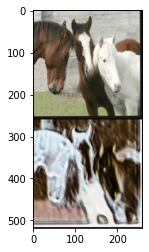

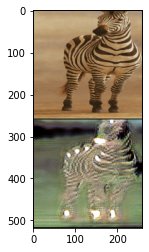

 56%|█████▌    | 597/1067 [06:21<05:04,  1.54it/s]

Step 7000: [G loss: 7.32667][D loss: 2.66823]


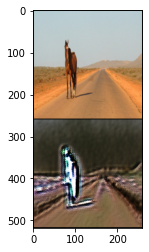

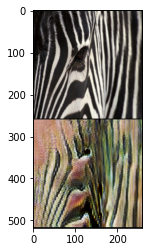

  3%|▎         | 30/1067 [00:19<10:57,  1.58it/s]

Step 7500: [G loss: 7.12262][D loss: 2.70994]


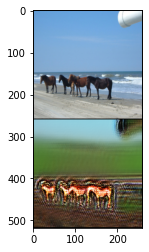

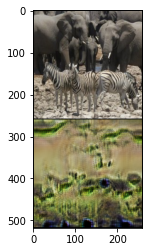

 50%|████▉     | 530/1067 [05:38<05:37,  1.59it/s]

Step 8000: [G loss: 7.05931][D loss: 2.69429]


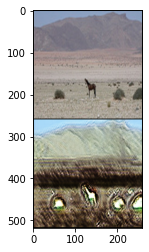

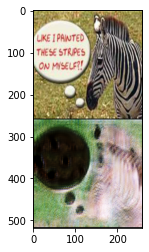

 97%|█████████▋| 1030/1067 [10:57<00:23,  1.55it/s]

Step 8500: [G loss: 7.11002][D loss: 2.69779]


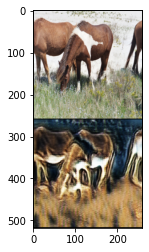

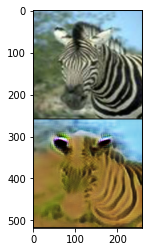

 43%|████▎     | 463/1067 [04:55<06:22,  1.58it/s]

Step 9000: [G loss: 6.95737][D loss: 2.72580]


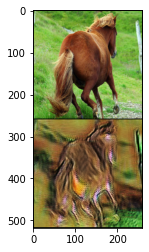

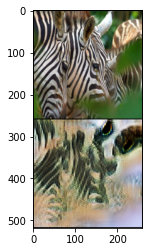

 90%|█████████ | 963/1067 [10:15<01:07,  1.53it/s]

Step 9500: [G loss: 6.95008][D loss: 2.69293]


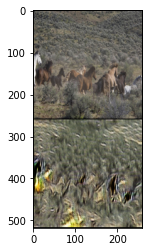

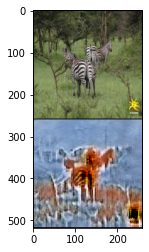

 37%|███▋      | 396/1067 [04:11<07:05,  1.58it/s]

Step 10000: [G loss: 6.95561][D loss: 2.72675]


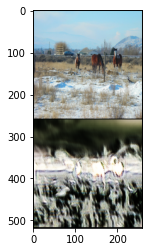

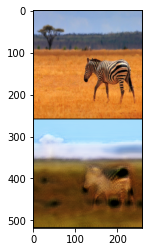

 84%|████████▍ | 896/1067 [09:31<01:50,  1.54it/s]

Step 10500: [G loss: 6.96415][D loss: 2.71627]


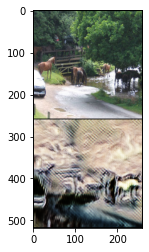

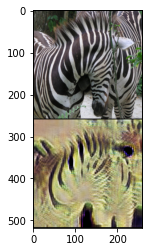

 31%|███       | 329/1067 [03:30<07:59,  1.54it/s]

Step 11000: [G loss: 6.81980][D loss: 2.72872]


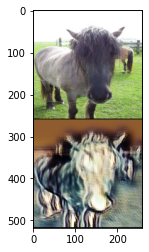

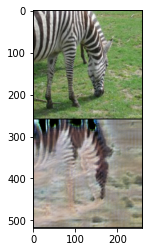

 78%|███████▊  | 829/1067 [08:49<02:31,  1.57it/s]

Step 11500: [G loss: 6.79978][D loss: 2.72224]


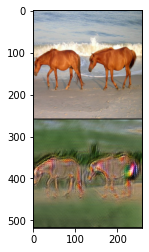

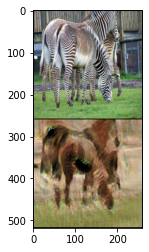

 25%|██▍       | 262/1067 [02:47<08:44,  1.53it/s]

Step 12000: [G loss: 6.81483][D loss: 2.73139]


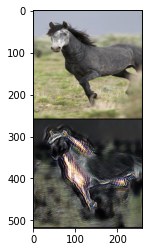

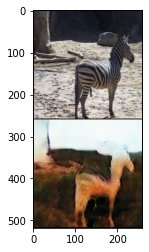

 71%|███████▏  | 762/1067 [08:06<03:15,  1.56it/s]

Step 12500: [G loss: 6.84320][D loss: 2.72663]


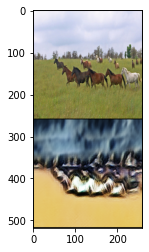

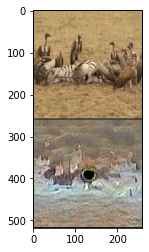

 18%|█▊        | 195/1067 [02:04<09:17,  1.56it/s]

Step 13000: [G loss: 6.83812][D loss: 2.68104]


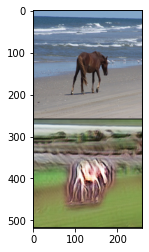

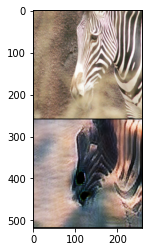

 25%|██▌       | 268/1067 [02:51<08:32,  1.56it/s]

In [ ]:
# Parse torch version for autocast
# ######################################################
version = torch.__version__
version = tuple(int(n) for n in version.split('.')[:-1])
has_autocast = version >= (1, 6)
# ######################################################

def train(munit, dataloader, optimizers, device):

    max_iters = 1000000
    decay_every = 100000
    cur_iter = 0

    display_every = 500
    mean_losses = [0., 0.]

    while cur_iter < max_iters:
        for (x_a, x_b) in tqdm(dataloader):
            x_a = x_a.to(device)
            x_b = x_b.to(device)

            # Enable autocast to FP16 tensors (new feature since torch==1.6.0)
            # If you're running older versions of torch, comment this out
            # and use NVIDIA apex for mixed/half precision training
            if has_autocast:
                with torch.cuda.amp.autocast(enabled=(device=='cuda')):
                    outputs = munit(x_a, x_b)
            else:
                outputs = munit(x_a, x_b)
            
            losses, x_ab, x_ba = outputs[:-2], outputs[-2], outputs[-1]
            munit.zero_grad()

            for i, (optimizer, loss) in enumerate(zip(optimizers, losses)):
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                mean_losses[i] += loss.item() / display_every

            cur_iter += 1

            if cur_iter % display_every == 0:
                print('Step {}: [G loss: {:.5f}][D loss: {:.5f}]'
                      .format(cur_iter, *mean_losses))
                show_tensor_images(x_ab, x_a)
                show_tensor_images(x_ba, x_b)
                mean_losses = [0., 0.]

            if cur_iter == max_iters:
                break

            # Schedule learning rate by 0.5
            if cur_iter % decay_every == 0:
                for optimizer in optimizers:
                    for param_group in optimizer.param_groups:
                        param_group['lr'] *= 0.5

train(
    munit, dataloader,
    [gen_optimizer, dis_optimizer],
    device,
)